# Institute of Information Project | Spectogram Generation

## General Information

### Questions and Answer

**1. Q1. Is this data related to rehabilitation processes or experiments?**
 - **Ans**: The data was collected using sensors embedded in an exercise machine designed for elderly users.

**2. Q2. Does each column in the Excel file represent an individual signal recording?**
 - **Ans**: Taking the `origin_normalize` file as an example, each row represents an individual sample. The variable inside each element in column `data_N` should be used as your algorithm input. For instance, the intersection in the first row and column `data_N` in the `original_normalize` file contains a series of sensor data over a specific time period and should serves as the input to your system. The label in the last column represents the corresponding desired output.
 - **Example**: The intersection in the first row and column `data_N` in the `original_normalize` file: `[0.21, 0.17, 0.15, 0.14, 0.1, 0.09, 0.1, 0.1, 0.11, 0.14, 0.19, 0.2, 0.21, 0.24, 0.24, 0.25, 0.27, 0.29, 0.30000000000000004, 0.38, 0.42, 0.43, 0.44]`

**3. Q3. I noticed that some of the data in the Excel file contains zeros, which might indicate that the signal did not persist throughout the entire recording period. Should I preprocess these sections (e.g., by removing or interpolating them), or should I leave the data as is?**
 - **Ans**: For the initial stage, we recommend selecting 50 samples from each class (0-7) and avoiding samples that contain zeros.

**4. Q4. Could you confirm the sampling rate of the device used to record the data?**
 - **Ans**:  I am not certain at the moment, but I will confirm with the data provider tomorrow. That said, it should not be a significant issue, as we are currently using a 1D-CNN to process the data.

### Data Information

- **RAW Data Sampling Rate**: `5 Hz`
- **Label**: 0-7
  - `0`: Fail
  - `1`: Try but fail
  - `2`: Speculative movement
  - `3`: Try very hard then pass
  - `4`: Good and hard try
  - `5`: Good but can better
  - `6`: Normal
  - `7`: Others
- `data.csv` Shape: `(96814, 230)`   
  - `0` - `228`: Sensor Data 
  - `229`: Class
  - `230`: Label
- `origin_normalize.csv` Shape: `(180454, 5)`
  - `Index` | `0` (Index) 
  - `th_H` | `1` (Threshold High)
  - `th_L` | `2` (Threshold Low)
  - `data_N` | `3` (Data Normalize)

## Importing Libraries

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from scipy.signal import spectrogram

## Utility Functions

In [94]:
# Convert the comma-separated string to a list of floats
def safe_convert_to_list(value):
    try:
        return [float(i.strip()) for i in value.split(',') if i.strip()]
    except ValueError:
        return None

## 1. Load Data

### Original Data Preprocessing

In [377]:
DATA_DIR = Path(r'D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA')

# `data.csv`
data = pd.read_csv(DATA_DIR / 'data.csv')
classes = data.iloc[:, -2]
label = data.iloc[:, -1]
sensor_data = data.iloc[:, :-2]

# `origin_normalize.csv`
origin_norm_path = os.path.join(DATA_DIR, 'origin_normalize.csv')
origin_norm = pd.read_csv(
    filepath_or_buffer=origin_norm_path,
    sep=',',  # Ensure the correct delimiter is used
    header=0,  # Assume the first row is the header
    skip_blank_lines=True,  # Skip completely blank lines
    usecols=lambda column: column.strip(),  # Exclude any extra columns if necessary
)

print(f"Original Classes Distribution: {origin_norm['label'].value_counts()}")

origin_norm_preprocessed = origin_norm.copy()
origin_norm_preprocessed['label'] = origin_norm_preprocessed['label'].apply(np.floor).astype('Int64')
origin_norm_preprocessed['data_N'] = origin_norm_preprocessed['data_N'].str.replace('[', '').str.replace(']', '')
origin_norm_preprocessed['data_N'] = origin_norm_preprocessed['data_N'].str.replace(r',\s*,', ',', regex=True).str.strip(',')
origin_norm_preprocessed['data_N'] = origin_norm_preprocessed['data_N'].apply(safe_convert_to_list)
origin_norm_preprocessed = origin_norm_preprocessed[origin_norm_preprocessed['data_N'].apply(lambda x: len(x) > 0)] # Remove rows where 'data_N' contains empty lists
origin_norm_preprocessed['data_N'] = origin_norm_preprocessed['data_N'].apply(lambda x: np.array(x) if isinstance(x, list) else x)
origin_norm_preprocessed = origin_norm_preprocessed[origin_norm_preprocessed['data_N'].apply(lambda x: isinstance(x, np.ndarray) and len(x) > 0)]

# Dynamically calculate the length of each sequence
origin_norm_preprocessed['data_length'] = origin_norm_preprocessed['data_N'].apply(len)

# User-defined recording length (adjust fs if necessary)
fs = 5  # Sampling frequency in Hz
desired_seconds = 4  # User-specified duration in seconds
desired_length = fs * desired_seconds  # Calculate the equivalent number of samples

# Filter data based on the desired length
filtered_data = origin_norm_preprocessed[origin_norm_preprocessed['data_length'] == desired_length]

print(filtered_data['label'].value_counts())

# Save the filtered dataset to a CSV file
filtered_csv_path = DATA_DIR / f'filtered_samples_length_{desired_length}.csv'
filtered_data.to_csv(filtered_csv_path, index=False)
print(f"Filtered dataset saved to: {filtered_csv_path}")

# Save the filtered dataset to Numpy format
filtered_npy_path = DATA_DIR / f'filtered_samples_length_{desired_length}.npy'
np.save(filtered_npy_path, filtered_data.values)
print(f"Filtered dataset saved to: {filtered_npy_path}")

# Randomly sample 50 samples per class (if needed)
sampled_data = filtered_data.groupby('label', group_keys=False).apply(
    lambda group: group.sample(n=min(50, len(group)), random_state=42)
)

# Save the sampled data to CSV
sampled_csv_path = DATA_DIR / f'random_sampled_length_{desired_length}.csv'
sampled_data.to_csv(sampled_csv_path, index=False)
print(f"Randomly sampled data saved to: {sampled_csv_path}")

# Save the sampled data to Numpy
sampled_npy_path = DATA_DIR / f'random_sampled_length_{desired_length}.npy'
np.save(sampled_npy_path, sampled_data.values)
print(f"Randomly sampled data saved to: {sampled_npy_path}")

#-------------------------------------------------------------------------------------------------------------------------------------------------------------#
# DEBUGGING
# Debugging: Print a sample
# print(origin_norm_preprocessed['data_N'].apply(type).value_counts())
# print("Sample data_N:", origin_norm_preprocessed['data_N'][0])
# print("Sample data_N Type: ", type(origin_norm_preprocessed['data_N'][0]))
# 
# # Sort from smallest to largest
# print("Label counts:\n", origin_norm_preprocessed['label'].value_counts(ascending=True))
# 
# # Debugging: Calculate and print statistics for `data_N`
# data_lengths = origin_norm_preprocessed['data_N'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0)
# shortest_data_idx = data_lengths.idxmin()
# longest_data_idx = data_lengths.idxmax()
# median_length = data_lengths.median()
# 
# # Debugging prints with lengths
# print(f"Shortest data (index {shortest_data_idx}, length {data_lengths[shortest_data_idx]}): {origin_norm_preprocessed.loc[shortest_data_idx, 'data_N']}")
# print(f"Longest data (index {longest_data_idx}, length {data_lengths[longest_data_idx]}): {origin_norm_preprocessed.loc[longest_data_idx, 'data_N']}")
# print(f"Median data length: {median_length}")
# 
# # Add a new column for the length of each `data_N` sequence
# origin_norm_preprocessed['data_length'] = origin_norm_preprocessed['data_N'].apply(len)
# 
# # Count the occurrences of each unique length
# length_counts = origin_norm_preprocessed['data_length'].value_counts().sort_index()
# 
# # Print the unique lengths and their counts
# print("Unique lengths and their counts:")
# for length, count in length_counts.items():
#     print(f"Length: {length}, Count: {count}")
# 
# # Filter samples with specified data_length
# # samples_in_range = origin_norm_preprocessed[(origin_norm_preprocessed['data_length'] = 127) & (origin_norm_preprocessed['data_length'] < 257)]
# samples_in_range = origin_norm_preprocessed[origin_norm_preprocessed['data_length'] == 20]
# 
# # Get value counts of the label for these samples
# label_counts_in_range = samples_in_range['label'].value_counts()
# 
# # Print the label counts
# print(label_counts_in_range)

# # Save the new dataset to a CSV file
# length_csv_path = DATA_DIR / 'origin_normalize_with_lengths.csv'
# origin_norm_preprocessed.to_csv(length_csv_path, index=False)
# 
# print(f"New dataset with lengths saved to: {length_csv_path}")
#-------------------------------------------------------------------------------------------------------------------------------------------------------------#

Original Classes Distribution: label
6    42816
5    37493
7    36897
1    24998
0    18786
3     7902
2     6673
4     4889
Name: count, dtype: int64
label
7    1569
6    1529
5    1397
1     984
0     709
3     278
2      79
4      66
Name: count, dtype: Int64
Filtered dataset saved to: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\filtered_samples_length_20.csv
Filtered dataset saved to: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\filtered_samples_length_20.npy


C:\Users\LENOVO X1E\AppData\Local\Temp\ipykernel_17780\781403232.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = filtered_data.groupby('label', group_keys=False).apply(


Randomly sampled data saved to: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\random_sampled_length_20.csv
Randomly sampled data saved to: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\random_sampled_length_20.npy


### Data Dummy Preprocessing

In [87]:
# Randomly sample 50 rows for each label
random_samples_per_label = (
    origin_norm.copy().groupby('label', group_keys=False)
    .apply(lambda group: group.sample(n=min(50, len(group)), random_state=42))
)

# Reset index to maintain continuity
random_samples_per_label = random_samples_per_label.reset_index(drop=True)

# Save into .csv
random_samples_per_label.to_csv(DATA_DIR / 'dummy_data.csv', index=False)

C:\Users\LENOVO X1E\AppData\Local\Temp\ipykernel_17780\1722274392.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  origin_norm.copy().groupby('label', group_keys=False)


In [96]:
dummy_data = os.path.join(DATA_DIR, 'dummy_data.csv')
dummy = pd.read_csv(dummy_data)

dummy_copy = dummy.copy()
data_N = dummy_copy['data_N']

# Remove square brackets and convert to numeric
dummy_copy['data_N'] = dummy_copy['data_N'].str.replace('[', '').str.replace(']', '')
dummy_copy['data_N'] = dummy_copy['data_N'].str.replace(r',\s*,', ',', regex=True).str.strip(',')

dummy_copy['data_N'] = dummy_copy['data_N'].apply(safe_convert_to_list)
print(type(dummy_copy['data_N'][0]))

# Remove rows where 'data_N' contains empty lists
dummy_copy = dummy_copy[dummy_copy['data_N'].apply(lambda x: len(x) > 0)]
print(dummy_copy['label'].value_counts())

<class 'list'>
label
6    34
3    33
0    31
1    27
5    27
7    25
2    20
4    19
Name: count, dtype: int64


### Training Data Preprocessing

#### Spectogram Visualization

Random Index: 107
Selected Signal Length: 20
X_random: [0.91 0.92 0.95 0.94 0.93 0.91 0.84 0.77 0.71 0.61 0.57 0.56 0.59 0.59
 0.6  0.62 0.62 0.62 0.67 0.68]
Frequencies: [0. 1. 2.]
Times: [0.5 1.5 2.5 3.5]


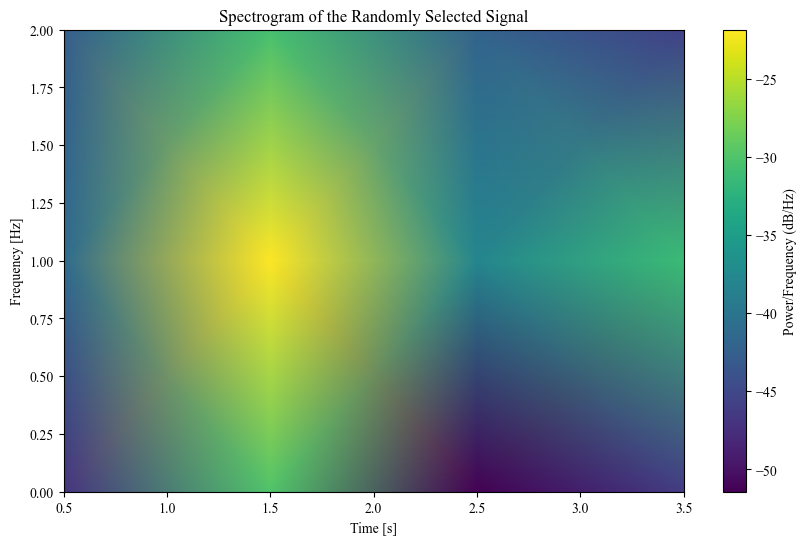

In [399]:
# Step 1: Load the data
RAW_DATA = np.load(DATA_DIR / 'random_sampled_length_20.npy', allow_pickle=True)
RAW_DATA = pd.DataFrame(RAW_DATA, columns=origin_norm_preprocessed.columns)

X = np.array(RAW_DATA['data_N'])
y = RAW_DATA['label']

# Step 2: Implement random indexing
random_indices = np.random.randint(0, len(X))
X_random = X[random_indices]  # Select a random sequence
print(f"Random Index: {random_indices}")
print(f"Selected Signal Length: {len(X_random)}")
print(f"X_random: {X_random}")

# Step 3: Generate and plot the spectrogram
frequencies, times, Sxx = spectrogram(X_random, fs=5, nperseg=5)  # Adjust `fs` as per your sampling rate

# Print spectrogram details
print(f"Frequencies: {frequencies}")
print(f"Times: {times}")

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram of the Randomly Selected Signal')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

#### Spectogram Generation

In [410]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from pathlib import Path

# Define data and output directories
DATA_DIR = Path(r'D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA')
OUTPUT_DIR = Path(DATA_DIR / 'Spectrogram Generation')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Step 1: Load the data
RAW_DATA = np.load(DATA_DIR / 'random_sampled_length_20.npy', allow_pickle=True)
RAW_DATA = pd.DataFrame(RAW_DATA, columns=origin_norm_preprocessed.columns)  # Replace with appropriate column names if different

X = np.array(RAW_DATA['data_N'])
y = RAW_DATA['label']

# Step 2: Generate spectrograms for all samples
fs = 5  # Sampling frequency
nperseg = 5  # Number of samples per segment

for idx, (signal, label) in enumerate(zip(X, y)):
    # Create subfolder for each class
    class_folder = OUTPUT_DIR / str(label)
    class_folder.mkdir(parents=True, exist_ok=True)

    # Generate the spectrogram
    frequencies, times, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg)

    # Plot the spectrogram without additional information
    plt.figure(figsize=(2, 2))  # Consistent size for DL models
    plt.axis('off')  # Remove axes
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), cmap='gray', shading='gouraud')

    # Save the spectrogram image
    output_path = class_folder / f'spectrogram_{idx}.png'
    plt.savefig(output_path, dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to save memory

    print(f"Saved spectrogram for sample {idx} in class {label}: {output_path}")

print("Spectrogram generation complete!")


Saved spectrogram for sample 0 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\Spectrogram Generation\0\spectrogram_0.png
Saved spectrogram for sample 1 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\Spectrogram Generation\0\spectrogram_1.png
Saved spectrogram for sample 2 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\Spectrogram Generation\0\spectrogram_2.png
Saved spectrogram for sample 3 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\Spectrogram Generation\0\spectrogram_3.png
Saved spectrogram for sample 4 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\Spectrogram Generation\0\spectrogram_4.png
Saved spectrogram for sample 5 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Info

C:\Users\LENOVO X1E\AppData\Local\Temp\ipykernel_17780\2580340566.py:35: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), cmap='gray', shading='gouraud')


Saved spectrogram for sample 6 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\Spectrogram Generation\0\spectrogram_6.png
Saved spectrogram for sample 7 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\Spectrogram Generation\0\spectrogram_7.png
Saved spectrogram for sample 8 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\Spectrogram Generation\0\spectrogram_8.png
Saved spectrogram for sample 9 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\Spectrogram Generation\0\spectrogram_9.png
Saved spectrogram for sample 10 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of Information\DATA\Spectrogram Generation\0\spectrogram_10.png
Saved spectrogram for sample 11 in class 0: D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\35. Institute of I